In [1]:
import data_smoothing
import find_peaks
import peak_character

# Load TA data

In [53]:
data_nm, data_time, data_z = data_smoothing.load_data_csv('exp06_20180119 -t0 -chirp.csv', 500, 800, 0)

# Smooth data

In [34]:
smooth_matx = data_smoothing.earth_smooth_matrix(data_nm, data_z)

/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/usr/local/lib/python3.5/dist-packages/sklearn_contrib_py_earth-0.1.0-py3.5-linux-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


# Find Peaks

In [35]:
threshold = 0.75
mindist = 0
idx, height, fwhm = peak_character.peak_matrix(data_nm,smooth_matx, threshold, mindist)

In [36]:
idx.describe()

,0,1,2,3,4
count,395.000000,139.000000,36.000000,3.000000,2.000000
mean,199.311392,221.985612,224.388889,216.666667,226.500000
std,29.723459,21.166348,19.770509,7.505553,6.363961
min,48.000000,154.000000,168.000000,209.000000,222.000000
25%,172.000000,213.500000,218.750000,213.000000,224.250000
50%,211.000000,223.000000,230.000000,217.000000,226.500000
75%,223.000000,240.000000,241.000000,220.500000,228.750000
max,246.000000,247.000000,246.000000,224.000000,231.000000


In [37]:
height.describe()

,0,1,2,3,4
count,395.000000,139.000000,36.000000,3.000000,2.000000
mean,-0.000205,-0.000189,-0.000180,0.000151,0.000043
std,0.000193,0.000249,0.000314,0.000032,0.000257
min,-0.000823,-0.000935,-0.000954,0.000126,-0.000139
25%,-0.000305,-0.000375,-0.000324,0.000133,-0.000048
50%,-0.000181,-0.000173,-0.000132,0.000140,0.000043
75%,-0.000115,-0.000075,-0.000025,0.000164,0.000134
max,0.000474,0.000579,0.000354,0.000188,0.000225


In [ ]:
height.loc[100:]

In [ ]:
data_nm.shape[0]

# Visualizer Function

In [7]:
import numpy as np
from scipy.optimize import differential_evolution
from scipy.special import gamma

def singleexpfunc(t, bounds):
    exp_array = 1-bounds[0] *np.exp((-1.0/bounds[1]) * t)

    return exp_array

def fit_single_exp_diffev(t, data):
    a1_bounds = (0, 2)
    tau1_bounds = (0, 100)
    bounds = [a1_bounds, tau1_bounds]
    time_array = t
    data_array = data
    def fit(params):
        decaymodel = singleexpfunc(time_array, params[:])
        cost = np.sum(((data_array - decaymodel) ** 2.0))
        return cost
    bestfit = differential_evolution(fit, bounds = bounds, polish = True)
    bestfit_params = bestfit.x
    def bestfit_decay(params):
        decaymodel = singleexpfunc(time_array, params[:])
        return decaymodel    
    bestfit_model = bestfit_decay(bestfit_params)   
    
    ss_res = np.sum((data_array - bestfit_model) ** 2.0)
    ss_tot = np.sum((data_array - np.mean(data_array)) ** 2.0)
    rsquare = 1 - (ss_res / ss_tot)
    
    return bestfit_params, bestfit_model, data_array, time_array

In [31]:
import matplotlib.figure as fig
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit

def visualize(peak_dict, data_nm):
    for i in range(len(peak_dict)):
        df = pd.DataFrame(peak_dict['peak_%s' % i], 
        columns=['Position', 'Height', 'Width', 'Time'])
        df = df.drop_duplicates(subset= 'Time')
        df = df.reset_index(drop=True)
        height_norm = np.linalg.norm(df['Height'], keepdims=True)
        print(height_norm)
        
        fit_params, exp_fit, data, time = fit_single_exp_diffev(df['Time'], df['Height'])
        
        plt.subplot(3, 1, 1)
        plt.plot(df['Time'], (df['Height']/height_norm), '.')
        #plt.plot(time, exp_fit)
        plt.title('Peak %s Dynamics' % (i+1))
        plt.ylabel('Intensity')

        plt.subplot(3, 1, 2)
        plt.plot(df['Time'], df['Position'], '.')
        plt.plot(np.unique(df['Time']), np.poly1d(np.polyfit(df['Time'], df['Position'], 1))(np.unique(df['Time'])))
        plt.ylabel('Position')
        plt.ylim((0, data_nm.shape[0]))

        plt.subplot(3, 1, 3)
        plt.plot(df['Time'], df['Width'], '.')
        plt.plot(np.unique(df['Time']), np.poly1d(np.polyfit(df['Time'], df['Width'], 1))(np.unique(df['Time'])))
        plt.ylabel('Width')
        plt.xlabel('Time')
        plt.tight_layout()
        plt.show()
    return

# Classify Peaks - KMeans

In [58]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def data_grouping(index_df, height_df, fwhm_df):
    peak_list = []
    
    for i in range(index_df.shape[0]):
        for j in range(index_df.shape[1]):
            peak_list.append(
            [index_df.loc[i,j], height_df.loc[i,j], fwhm_df.loc[i,j], i])
        
    all_points = pd.DataFrame(peak_list, 
    columns=['Position', 'Height', 'Width', 'Time'])
    fill_na = all_points.fillna(value=0)
    corrected_output = fill_na.drop(fill_na[abs(fill_na.Height) < 0.0002].index)
    corrected_output = corrected_output.reset_index(drop=True)
    
    return corrected_output

def cluster_classifier(index_df, corrected_output):
    found_peak = index_df.shape[1]
    cluster = KMeans(n_clusters=found_peak).fit(corrected_output.iloc[:,:-2])
    print(cluster.labels_)
    print(cluster.cluster_centers_)
    cluster_dict = {}
    
    for i in range(found_peak):
            cluster_dict['peak_%s' % i] = []
            
    for j in range(corrected_output.shape[0]):
        peak = cluster.predict([corrected_output.values[j,:-2]])
        for k in range(found_peak):
            if (peak == k):
                cluster_dict['peak_%s' % k].append(corrected_output.values[j])
                #print('found a match')

    peak_dict = { k:v for k, v in cluster_dict.items() if len(v) >= 5}
    return peak_dict

In [43]:
corrected_output = data_grouping(idx, height, fwhm)
corrected_output.describe()

,Position,Height,Width,Time
count,279.000000,279.000000,279.000000,279.000000
mean,211.336918,-0.000321,56.469473,280.702509
std,25.402255,0.000236,35.240762,193.918995
min,163.000000,-0.000954,4.793000,3.000000
25%,188.000000,-0.000438,26.467000,135.000000
50%,222.000000,-0.000322,42.084000,224.000000
75%,223.500000,-0.000242,90.193000,427.500000
max,247.000000,0.000579,135.411000,681.000000


In [59]:
peak_dict = cluster_classifier(idx, corrected_output)

[0 2 2 2 0 2 0 2 2 2 0 2 1 0 1 0 0 2 1 4 2 1 0 0 2 1 0 0 4 0 1 4 2 1 0 0 0
 4 0 0 2 1 0 1 2 1 0 0 2 1 0 1 2 1 4 2 1 0 0 0 2 2 1 2 1 2 1 0 2 1 1 1 0 1
 1 0 2 1 3 2 1 0 0 4 0 2 0 0 0 0 0 0 2 1 2 0 0 1 0 2 1 2 1 2 1 2 1 0 0 0 1
 2 0 0 0 2 1 2 1 0 3 2 1 2 0 0 1 0 2 0 0 4 2 1 2 1 0 0 1 0 2 1 2 0 0 0 0 0
 2 1 2 4 2 1 0 0 0 2 2 2 1 0 0 4 3 2 2 2 1 2 1 1 2 2 0 4 1 2 1 1 1 2 2 2 1
 2 2 2 2 3 2 4 2 1 2 2 2 2 2 4 2 1 2 2 2 2 4 2 2 2 2 2 2 2 2 1 2 2 2 2 2 4
 2 1 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 4 4 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 4 2
 2 3 2 3 3 2 2 3 3 3 2 3 2 3 2 3 2 2 3 2]
[[ 1.71830769e+02 -3.79316647e-04]
 [ 2.42259259e+02 -4.35056474e-04]
 [ 2.22380952e+02 -2.63873382e-04]
 [ 2.05000000e+02 -1.55926284e-04]
 [ 1.90368421e+02 -3.05926725e-04]]


In [60]:
peak_dict

{'peak_0': [array([ 1.69000000e+02, -2.11573275e-04,  4.41810000e+01,  3.00000000e+00]),
  array([ 1.76000000e+02, -3.01974053e-04,  7.99310000e+01,  6.00000000e+00]),
  array([ 1.76000000e+02, -3.21638935e-04,  9.68490000e+01,  7.00000000e+00]),
  array([ 1.76000000e+02, -5.48528691e-04,  7.65270000e+01,  1.10000000e+01]),
  array([ 1.75000000e+02, -6.64127754e-04,  7.53070000e+01,  1.20000000e+01]),
  array([ 1.740000e+02, -6.529862e-04,  9.440800e+01,  1.300000e+01]),
  array([ 1.75000000e+02, -7.32440777e-04,  8.72610000e+01,  1.40000000e+01]),
  array([ 1.74000000e+02, -7.66266063e-04,  8.36910000e+01,  1.60000000e+01]),
  array([ 1.73000000e+02, -8.22908281e-04,  6.93170000e+01,  1.70000000e+01]),
  array([ 1.76000000e+02, -6.90194431e-04,  1.06512000e+02,  4.90000000e+01]),
  array([ 1.76000000e+02, -7.22048325e-04,  6.69010000e+01,  5.20000000e+01]),
  array([ 1.74000000e+02, -5.46766651e-04,  1.08891000e+02,  7.90000000e+01]),
  array([ 1.68000000e+02, -4.66290223e-04,  7.7647

In [47]:
len(peak_dict)

3

# Peak Dynamics With Classifying

[0.00327869]


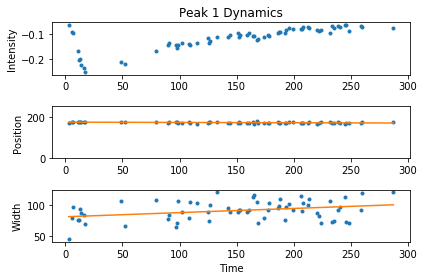

[0.00344488]


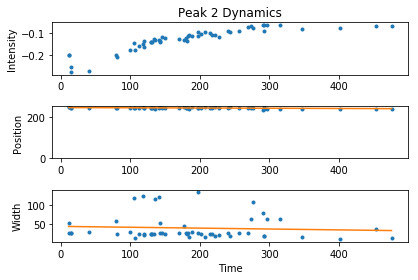

[0.00416558]


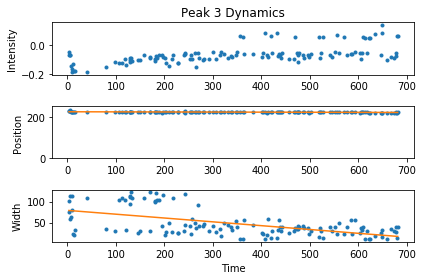

[0.00107702]


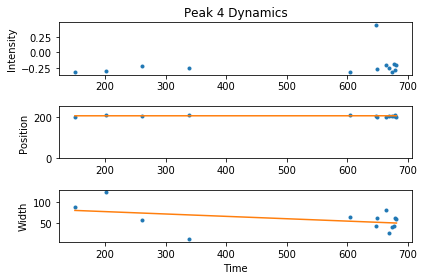

[0.00169555]


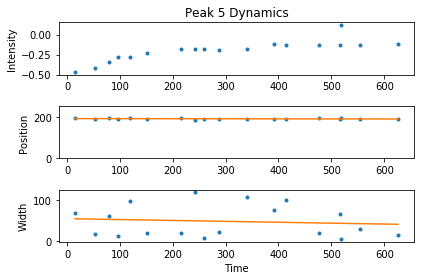

In [61]:
KMeans_output = visualize(peak_dict, data_nm)

# Peak Dynamics Without Classifying

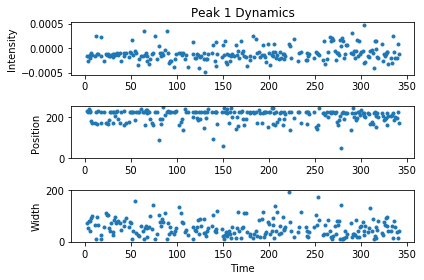

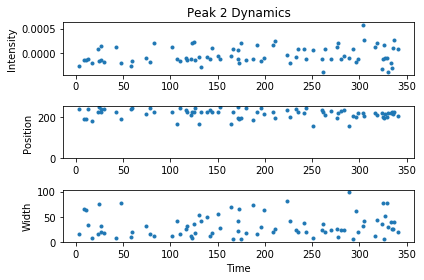

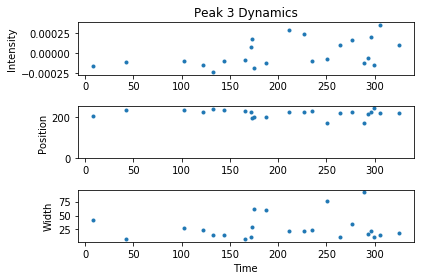

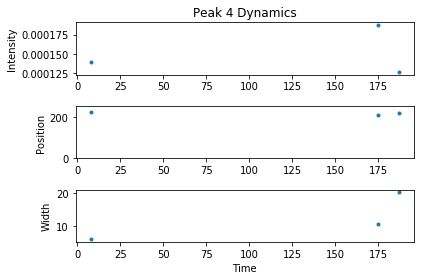

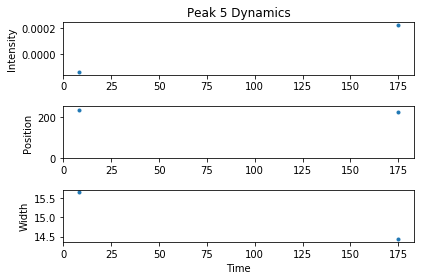

In [30]:
for i in range(idx.shape[1]):
        plt.subplot(3, 1, 1)
        plt.plot(height.loc[:, i], '.')
        plt.title('Peak %s Dynamics' % (i+1))
        plt.ylabel('Intensity')

        plt.subplot(3, 1, 2)
        plt.plot(idx.loc[:, i], '.')
        plt.ylabel('Position')
        plt.ylim((0, data_nm.shape[0]))

        plt.subplot(3, 1, 3)
        plt.plot(fwhm.loc[:, i], '.')
        plt.ylabel('Width')
        plt.xlabel('Time')
        plt.tight_layout()
        plt.show()

# True Data:
* Peak 1: Intense peak at ~950nm (idx~20), maximum intensity ~-0.005, disappears by time 300.
* Peak 2: Broad peak at ~1100nm (idx~50), maximum intensity ~-0.0015, grows in at time 200 and persists for duration of experiment.

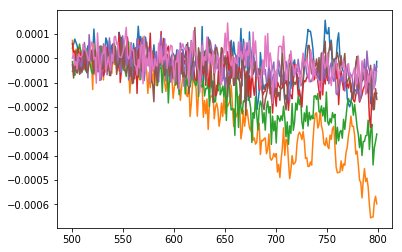

In [54]:
plt.plot(data_nm, data_z[:,1::100])

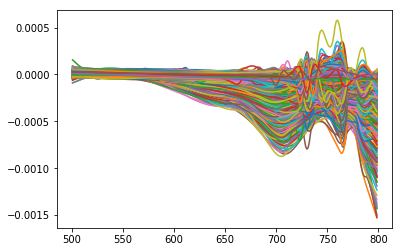

In [69]:
plt.plot(data_nm, smooth_matx)

In [66]:
len(smooth_matx)

252